Header Files

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim


In [2]:
%run "D:/Athreya/Git_folders/DML-Project/dml_function/DL_functions.py"

Data Reading

In [3]:
B05 = pd.read_csv('../Battery_data/B0005_discharge_.csv')
B06 = pd.read_csv('../Battery_data/B0006_discharge_.csv')
B07 = pd.read_csv('../Battery_data/B0007_discharge.csv')
B18 = pd.read_csv('../Battery_data/B0018_discharge_.csv')

# print the first few rows
print(B05.head(0))
B05.shape
df = B05  # assigning B05 as the data we are concerned about
B05.head(0).columns


Empty DataFrame
Columns: [cycle, ambient_temperature, capacity, voltage_measured, current_measured, temperature_measured, current_load, voltage_load, time, RUL]
Index: []


Index(['cycle', 'ambient_temperature', 'capacity', 'voltage_measured',
       'current_measured', 'temperature_measured', 'current_load',
       'voltage_load', 'time', 'RUL'],
      dtype='object')

Data visualization

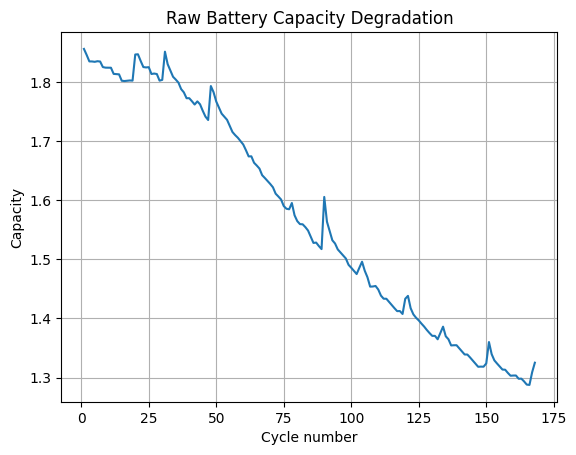

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df['cycle'], df['capacity'])
plt.xlabel('Cycle number')
plt.ylabel('Capacity')
plt.title('Raw Battery Capacity Degradation')
plt.grid(True)
plt.show()

Parameter Evaluation

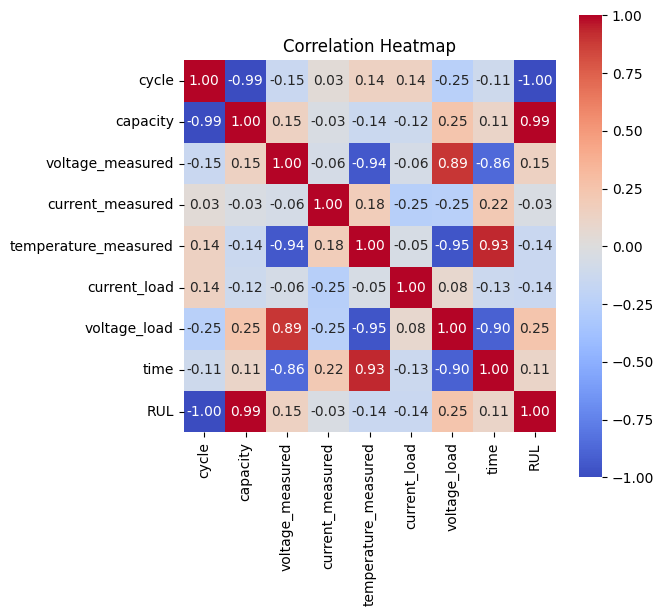

In [5]:
corr = df[['cycle','capacity','voltage_measured','current_measured','temperature_measured','current_load','voltage_load','time','RUL']].corr(method='spearman')
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()



 # DATA PREPROCESSING
Identifying the necessary features as inputs except cycles


In [6]:
# list of input sequences (per cycle)
feature_cols = ["voltage_measured", "current_measured", "temperature_measured",
                "current_load", "voltage_load", "time"]

 Normalization/Scaler function to transform features by scaling each feature to a given range.


In [7]:
from sklearn.preprocessing import MinMaxScaler

scalers = {c: MinMaxScaler() for c in feature_cols}

for c in feature_cols:
    df[c] = scalers[c].fit_transform(df[[c]])

target_scaler = MinMaxScaler()
df["capacity"] = target_scaler.fit_transform(df[["capacity"]])


Create X and y and pad the sequences

In [8]:
x_data, y_data = [], []
for cycle, group in df.groupby("cycle"):
    x_data.append(group[feature_cols].values)
    y_data.append(group["capacity"].iloc[-1])


# pad sequences to same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_data = pad_sequences(x_data, dtype='float32', padding='pre')
y_data = np.array(y_data, dtype='float32')
x_data.shape

(168, 371, 6)

Data Splitting

In [9]:
from sklearn.model_selection import train_test_split

X_, x_test, Y_, y_test = train_test_split(x_data,y_data,test_size = 0.1, shuffle = False)
x_train, x_val, y_train, y_val = train_test_split(X_,Y_,test_size = 0.1, shuffle = False)

Create DataLoaders

In [10]:
batch_size = 128
train_ds = DS(x_train,y_train)
val_ds = DS(x_val,y_val)
test_ds = DS(x_test,y_test)
train_loader = DataLoader(train_ds,batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size,shuffle=False)
test_loader = DataLoader(test_ds, batch_size, shuffle=False)

# GRU Model 
Training and validation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = x_train.shape[2]
hidden_size = 256
output_size = 1
num_epochs = 80

# model = GRULayer(input_size, hidden_size, output_size).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# train_losses, val_losses = train_n_validate(
#     model, train_loader, val_loader, num_epochs, optimizer, criterion, device
# )




Epoch [1/80] - Train Loss: 0.3924 | Val Loss: 0.4004
Epoch [2/80] - Train Loss: 0.1988 | Val Loss: 0.7867
Epoch [3/80] - Train Loss: 0.1567 | Val Loss: 0.4490
Epoch [4/80] - Train Loss: 0.0964 | Val Loss: 0.1940
Epoch [5/80] - Train Loss: 0.0926 | Val Loss: 0.1043
Epoch [6/80] - Train Loss: 0.0922 | Val Loss: 0.1087
Epoch [7/80] - Train Loss: 0.1009 | Val Loss: 0.1666
Epoch [8/80] - Train Loss: 0.0692 | Val Loss: 0.2508
Epoch [9/80] - Train Loss: 0.0908 | Val Loss: 0.2956
Epoch [10/80] - Train Loss: 0.0659 | Val Loss: 0.2771
Epoch [11/80] - Train Loss: 0.0735 | Val Loss: 0.2214
Epoch [12/80] - Train Loss: 0.0543 | Val Loss: 0.1563
Epoch [13/80] - Train Loss: 0.0498 | Val Loss: 0.1111
Epoch [14/80] - Train Loss: 0.0310 | Val Loss: 0.0867
Epoch [15/80] - Train Loss: 0.0340 | Val Loss: 0.0699
Epoch [16/80] - Train Loss: 0.0309 | Val Loss: 0.0664
Epoch [17/80] - Train Loss: 0.0251 | Val Loss: 0.0734
Epoch [18/80] - Train Loss: 0.0125 | Val Loss: 0.0773
Epoch [19/80] - Train Loss: 0.0217 | 

Save the model

In [ ]:
#torch.save(model.state_dict(), "battery_rul_model.pt")

Call the model

In [16]:
model = GRULayer(input_size, hidden_size, output_size)
model.load_state_dict(torch.load("battery_rul_model.pt"))
model.eval()  # Set to evaluation mode

C:\Users\talla\AppData\Local\Temp\ipykernel_21324\4105140939.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("battery_rul_model.pt"))


GRULayer(
  (gru_nodes): ModuleList(
    (0): GRU_Node(
      (Wz): Linear(in_features=6, out_features=256, bias=True)
      (Uz): Linear(in_features=256, out_features=256, bias=False)
      (Wr): Linear(in_features=6, out_features=256, bias=True)
      (Ur): Linear(in_features=256, out_features=256, bias=False)
      (Wh): Linear(in_features=6, out_features=256, bias=True)
      (Uh): Linear(in_features=256, out_features=256, bias=False)
    )
  )
  (dropouts): ModuleList()
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

Plot the training parameters

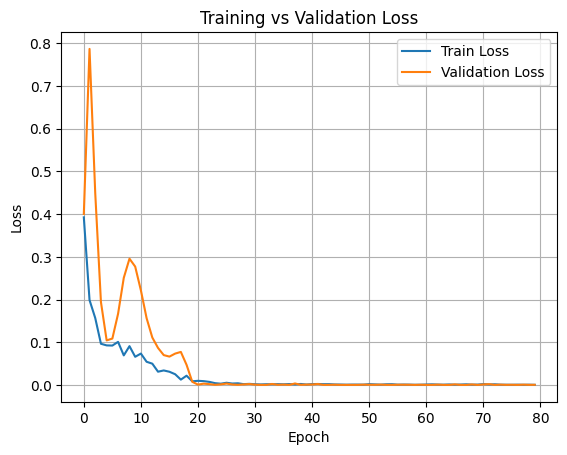

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Model Validation

Plotting the prediction

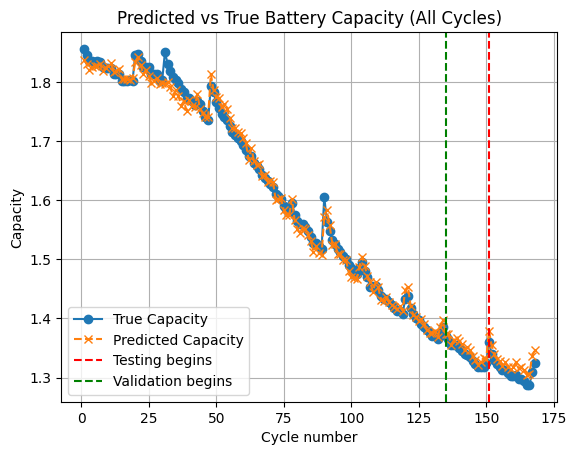

In [13]:
y_all_true = np.concatenate([y_train,y_val,y_test])
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(np.concatenate([x_train,x_val,x_test]), dtype=torch.float32).to(device)
    _,_,y_pred = model(X_tensor)
y_pred = y_pred.cpu().squeeze().numpy()

y_pred_unscaled = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_unscaled = target_scaler.inverse_transform(y_all_true.reshape(-1, 1)).flatten()

cycles = np.arange(1, len(y_all_true) + 1)

plt.figure()
plt.plot(cycles, y_true_unscaled, 'o-', label='True Capacity')
plt.plot(cycles, y_pred_unscaled, 'x--', label='Predicted Capacity')
test_start = len(y_train) + len(y_val)
plt.axvline(x=test_start, color='red', linestyle='--', label='Testing begins')
val_start = len(y_train)
plt.axvline(x=val_start, color='green', linestyle='--', label='Validation begins')

plt.xlabel('Cycle number')
plt.ylabel('Capacity')
plt.title('Predicted vs True Battery Capacity (All Cycles)')
plt.legend()
plt.grid(True)
plt.show()


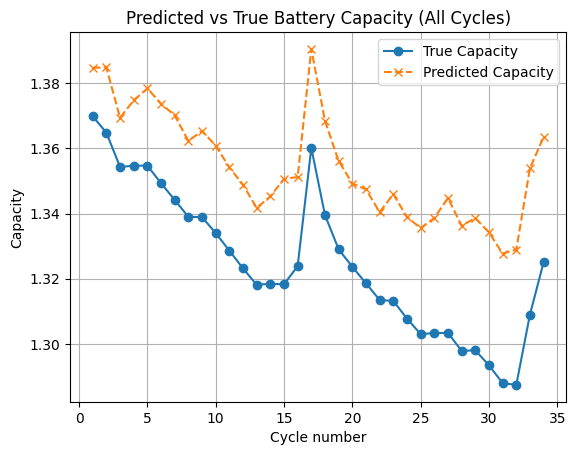

In [30]:
model.eval()
with torch.no_grad():
    X_tensor_tst = torch.tensor(x_test, dtype=torch.float32).to(device)
    _,_,y_pred_tst = model(X_tensor_tst)
y_pred_tst = y_pred_tst.cpu().squeeze().numpy()
cycles_tst = np.arange(1, len(y_pred_tst) + 1)


y_pred_unscaled_tst = target_scaler.inverse_transform(y_pred_tst.reshape(-1, 1)).flatten()
y_true_unscaled_tst = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
plt.figure()
plt.plot(cycles_tst, y_true_unscaled_tst, 'o-', label='True Capacity')
plt.plot(cycles_tst, y_pred_unscaled_tst, 'x--', label='Predicted Capacity')


plt.xlabel('Cycle number')
plt.ylabel('Capacity')
plt.title('Predicted vs True Battery Capacity (All Cycles)')
plt.legend()
plt.grid(True)
plt.show()


Compute the performance

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true_unscaled_tst, y_pred_unscaled_tst)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_unscaled_tst, y_pred_unscaled_tst)
r2 = r2_score(y_true_unscaled_tst, y_pred_unscaled_tst)

print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

MSE  = 0.0009
RMSE = 0.0305
MAE  = 0.0296
R²   = -0.8912


# Model Validation for other battery(completely unseen data)

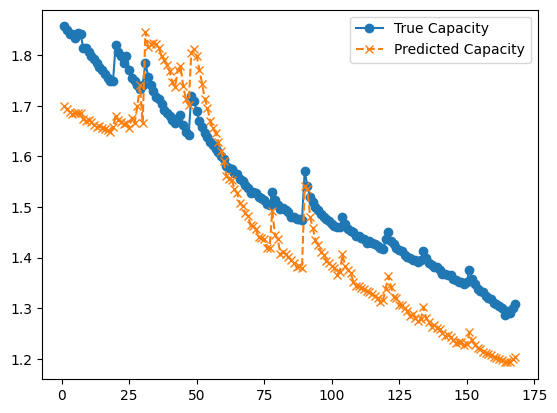

In [48]:
df6 = B06
scalers_test = {c: MinMaxScaler() for c in feature_cols}

for c in feature_cols:
    df6[c] = scalers_test[c].fit_transform(df6[[c]])

target_scaler_test = MinMaxScaler()
df6["capacity"] = target_scaler_test.fit_transform(df6[["capacity"]])


x6_data, y6_data = [], []
for cycle, group in df6.groupby("cycle"):
    x6_data.append(group[feature_cols].values)
    y6_data.append(group["capacity"].iloc[-1])


# pad sequences to same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
x6_data = pad_sequences(x6_data, dtype='float32', padding='pre')
y6_data = np.array(y6_data, dtype='float32')

with torch.no_grad():
    X6_tensor = torch.tensor(x6_data, dtype=torch.float32).to(device)
    _,_,y6_pred = model(X6_tensor)

y6_act_unscaled = target_scaler.inverse_transform(y6_data.reshape(-1, 1)).flatten()
y6_pred_unscaled = target_scaler.inverse_transform(y6_pred.reshape(-1, 1)).flatten()


cycles_6 = np.arange(1, len(y6_act_unscaled) + 1)

plt.figure()
plt.plot(cycles_6, y6_act_unscaled, 'o-', label='True Capacity')
plt.plot(cycles_6, y6_pred_unscaled, 'x--', label='Predicted Capacity')
plt.legend()
